### Imports and Environment Setup

This cell initializes the core Python libraries used throughout the analysis.

- Pandas is used for data loading, manipulation, and aggregation.
- NumPy supports numerical operations and handling special values.
- Matplotlib is used for visualizing trends and comparisons.
- Glob enables dynamic loading of multiple dataset files.

Display options are adjusted to improve readability when inspecting large tables.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


### Identifying Dataset Files

The dataset is distributed across multiple compressed CSV files.

This step locates all `.csv.gz` files in the working directory to ensure that all data parts are included before loading.


In [2]:
file_paths = glob.glob("*.csv.gz")

len(file_paths)


17

### Loading and Combining Data Files

All dataset files are loaded individually and combined into a single DataFrame.

This process is equivalent to a `UNION ALL` operation in SQL and allows the analysis to be performed on a unified dataset.


In [3]:
df_list = []

for path in file_paths:
    temp_df = pd.read_csv(path, compression="gzip")
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

df.shape


(7293526, 14)

### Initial Data Preview

The first few rows of the dataset are displayed to verify column names and inspect example values.

This provides a quick sanity check before deeper inspection.


In [4]:
df.head()


,user_id,event_date,platform,install_date,country,total_session_count,total_session_duration,match_start_count,match_end_count,victory_count,defeat_count,server_connection_error,iap_revenue,ad_revenue
0,C6C0A027C49B98BA,2024-02-16,android,2024-02-11,NaN,1,57.721,0,0,0,0,0,0.0,0.0
1,EE03D492BC0ED08C,2024-03-08,ios,2024-02-01,NaN,0,0.355,0,0,0,0,0,0.0,0.0
2,5CAA4AF817354059,2024-03-12,ios,2024-03-12,NaN,1,114.006,0,0,0,0,0,0.0,0.0
3,EF0DE79217D56E72,2024-02-16,ios,2023-07-24,NaN,0,8.157,0,0,0,0,0,0.0,0.0
4,6DD3D1FC631486F0,2024-03-02,android,2024-03-01,NaN,1,233.265,1,0,0,0,0,0.0,0.0


### Dataset Structure Overview

This step reviews data types, memory usage, and missing values across all columns.

Understanding the structure of the dataset helps prevent type-related errors in later analysis.


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7293526 entries, 0 to 7293525
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   user_id                  object 
 1   event_date               object 
 2   platform                 object 
 3   install_date             object 
 4   country                  object 
 5   total_session_count      int64  
 6   total_session_duration   float64
 7   match_start_count        int64  
 8   match_end_count          int64  
 9   victory_count            int64  
 10  defeat_count             int64  
 11  server_connection_error  int64  
 12  iap_revenue              float64
 13  ad_revenue               float64
dtypes: float64(3), int64(6), object(5)
memory usage: 779.0+ MB


### Missing Value Analysis

Missing values are counted for each column to identify potential data quality issues.

This information is used later to decide whether values should be cleaned, replaced, or excluded.


In [6]:
df.isna().sum()


user_id                        0
event_date                     0
platform                       0
install_date                   0
country                    17998
total_session_count            0
total_session_duration         0
match_start_count              0
match_end_count                0
victory_count                  0
defeat_count                   0
server_connection_error        0
iap_revenue                    0
ad_revenue                     0
dtype: int64

### Column Validation

All column names are listed to confirm alignment with the expected schema.

This step reduces the risk of referencing incorrect or misspelled columns in subsequent calculations.


In [7]:
df.columns


Index(['user_id', 'event_date', 'platform', 'install_date', 'country', 'total_session_count', 'total_session_duration',
       'match_start_count', 'match_end_count', 'victory_count', 'defeat_count', 'server_connection_error',
       'iap_revenue', 'ad_revenue'],
      dtype='object')

### Date Parsing

Event and install dates are converted from string format into datetime objects.

This enables accurate time-based calculations such as lifecycle analysis and trend evaluation.


In [8]:
df["event_date"] = pd.to_datetime(df["event_date"])
df["install_date"] = pd.to_datetime(df["install_date"])


### Feature Engineering: Days Since Install

A new feature is created to calculate how many days have passed between installation and each recorded event.

This metric is essential for lifecycle segmentation and retention-related analysis.


In [9]:
df["days_since_install"] = (df["event_date"] - df["install_date"]).dt.days


### Lifecycle Timing Validation

Summary statistics are used to verify that lifecycle timing values are logical.

This helps detect invalid records such as events occurring before installation.


In [10]:
df["days_since_install"].describe()


count    7.293526e+06
mean     1.704216e+02
std      2.672715e+02
min     -1.000000e+00
25%      3.000000e+00
50%      3.700000e+01
75%      2.280000e+02
max      2.272000e+03
Name: days_since_install, dtype: float64

### Feature Engineering: Engagement Metrics

Two normalized engagement metrics are created:

- Average session duration per session
- Match win rate

These metrics provide more meaningful behavioral insights than raw counts.


In [11]:
df["session_duration_per_session"] = (
    df["total_session_duration"] / df["total_session_count"]
)

df["win_rate"] = df["victory_count"] / (
    df["victory_count"] + df["defeat_count"]
)


### Engagement Metric Validation

Summary statistics are reviewed to identify invalid or extreme values resulting from division operations.

This step ensures that derived metrics are suitable for aggregation and visualization.


In [12]:
df[[
    "session_duration_per_session",
    "win_rate"
]].describe()


,session_duration_per_session,win_rate
count,7292306.000,4.939642e+06
mean,inf,6.011821e-01
std,NaN,3.498894e-01
min,0.000,0.000000e+00
25%,185.504,3.750000e-01
50%,530.563,6.666667e-01
75%,1165.669,1.000000e+00
max,inf,1.000000e+00


### Data Cleaning

Several data quality issues are addressed:

- Invalid lifecycle records are removed.
- Infinite values caused by division by zero are replaced with nulls.
- Missing country values are labeled as "Unknown".

These steps improve the reliability of downstream analysis.


In [14]:
# Keep only valid records where event_date is on or after install_date
initial_row_count = len(df)
df = df[df["days_since_install"] >= 0]

# Replace infinite values caused by division by zero with NaN
df["session_duration_per_session"] = (
    df["session_duration_per_session"]
    .replace([np.inf, -np.inf], np.nan)
)

# Fill missing country values with a meaningful label
df["country"] = df["country"].fillna("Unknown")

final_row_count = len(df)
initial_row_count, final_row_count


(7293525, 7293525)

### Post-cleaning Validation

Key metrics are reviewed again to confirm that cleaning steps were applied correctly.

This ensures the dataset is fully prepared for analytical exploration.


In [15]:
df[
    [
        "days_since_install",
        "session_duration_per_session",
        "win_rate"
    ]
].describe()


,days_since_install,session_duration_per_session,win_rate
count,7.293525e+06,7.288197e+06,4.939641e+06
mean,1.704217e+02,8.957961e+02,6.011822e-01
std,2.672715e+02,1.282896e+03,3.498893e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.852950e+02,3.750000e-01
50%,3.700000e+01,5.300690e+02,6.666667e-01
75%,2.280000e+02,1.164053e+03,1.000000e+00
max,2.272000e+03,6.167704e+05,1.000000e+00


### User Lifecycle Segmentation

Users are grouped into lifecycle stages based on time since installation.

This segmentation allows behavioral and monetization comparisons across different stages of user maturity.


In [16]:
# Define user lifecycle segments based on days since install
df["lifecycle_segment"] = pd.cut(
    df["days_since_install"],
    bins=[-1, 1, 7, 30, 90, np.inf],
    labels=["D0-D1", "D2-D7", "D8-D30", "D31-D90", "D90+"]
)

df["lifecycle_segment"].value_counts().sort_index()


lifecycle_segment
D0-D1      1546374
D2-D7       854975
D8-D30     1054642
D31-D90    1238475
D90+       2599059
Name: count, dtype: int64

### Aggregated Metrics by Lifecycle Segment

Engagement and monetization metrics are aggregated at the lifecycle segment level.

This provides a clear comparison of how user value evolves over time.


In [18]:
# Aggregate engagement and monetization metrics by lifecycle segment
segment_metrics = (
    df
    .groupby("lifecycle_segment", observed=False)
    .agg(
        avg_session_duration=("session_duration_per_session", "mean"),
        avg_win_rate=("win_rate", "mean"),
        avg_iap_revenue=("iap_revenue", "mean"),
        avg_ad_revenue=("ad_revenue", "mean"),
        user_count=("user_id", "count")
    )
    .reset_index()
)

segment_metrics



,lifecycle_segment,avg_session_duration,avg_win_rate,avg_iap_revenue,avg_ad_revenue,user_count
0,D0-D1,792.476245,0.659320,0.031374,0.022890,1546374
1,D2-D7,774.139514,0.672154,0.088237,0.024726,854975
2,D8-D30,880.271053,0.601097,0.155955,0.022309,1054642
3,D31-D90,930.433288,0.544890,0.182676,0.016817,1238475
4,D90+,987.060510,0.557074,0.161176,0.017498,2599059


### Engagement Across Lifecycle Stages

This visualization shows how average session duration increases as users progress through lifecycle stages.

Long-term users demonstrate significantly deeper engagement.


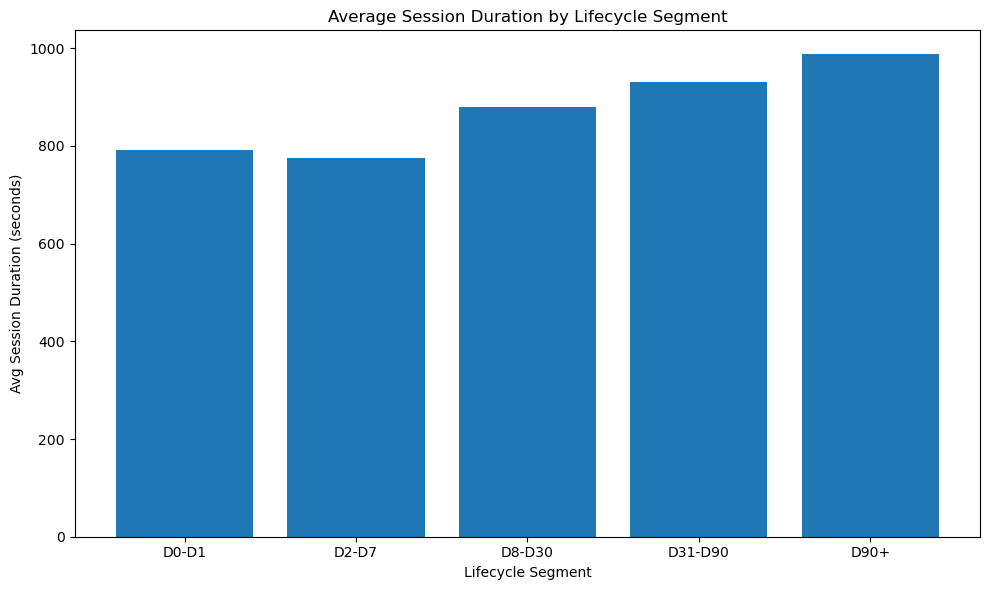

In [19]:
# Plot average session duration by lifecycle segment
plt.figure(figsize=(10, 6))

plt.bar(
    segment_metrics["lifecycle_segment"],
    segment_metrics["avg_session_duration"]
)

plt.title("Average Session Duration by Lifecycle Segment")
plt.xlabel("Lifecycle Segment")
plt.ylabel("Avg Session Duration (seconds)")

plt.tight_layout()
plt.show()


### Monetization Trends Across Lifecycle

This chart highlights how in-app purchases increase with user engagement, while ad revenue remains relatively stable.

The results suggest a shift from ad-based to IAP-based monetization as users mature.


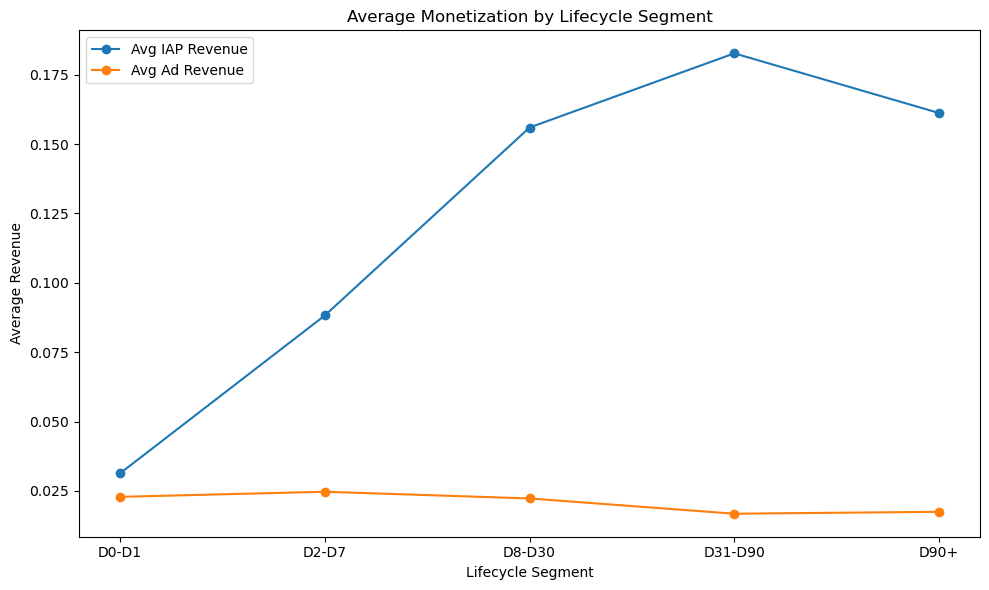

In [23]:
# Plot monetization metrics by lifecycle segment
plt.figure(figsize=(10, 6))

plt.plot(
    segment_metrics["lifecycle_segment"],
    segment_metrics["avg_iap_revenue"],
    marker="o",
    label="Avg IAP Revenue"
)

plt.plot(
    segment_metrics["lifecycle_segment"],
    segment_metrics["avg_ad_revenue"],
    marker="o",
    label="Avg Ad Revenue"
)

plt.title("Average Monetization by Lifecycle Segment")
plt.xlabel("Lifecycle Segment")
plt.ylabel("Average Revenue")
plt.legend()

plt.tight_layout()
plt.show()


## Key Insights

- User engagement increases steadily with lifecycle progression. Long-term users spend significantly more time per session compared to new users.

- IAP monetization peaks in mid-to-late lifecycle stages (D8–D90), suggesting that users are more willing to spend once they are sufficiently engaged with the game.

- Ad revenue remains relatively stable across segments but slightly declines for long-term users, indicating a potential shift from ad-based to IAP-based monetization.

- Win rate decreases as users progress in the lifecycle, which may indicate increasing game difficulty or matchmaking adjustments over time.
